In [23]:
# decontX: Remove ambient RNA from EmptyDrops filtered cells, with marker genes for prior clustering
# This version loads marker genes from colorcodes.json for all major testis cell types.
# Handles the edge case: if only one cluster present, skips z.

library(celda)
library(SingleCellExperiment)
library(DropletUtils)
library(Matrix)
library(zellkonverter)
library(HDF5Array)
library(jsonlite)

# =============================================================================
# File paths (your original structure)
# =============================================================================
data_dir <- "../data"
raw_h5 <- file.path(data_dir, "raw_feature_bc_matrix.h5")
filtered_h5 <- file.path(data_dir, "filtered_feature_bc_matrix.h5")
empty_drops_h5ad <- file.path(data_dir, "pyED_correct.h5ad")
cell_types_csv <- file.path(data_dir, "cell_types.csv")
colorcodes_json <- file.path(data_dir, "colorcodes.json")

cat("Checking files:\n")
cat("  Raw matrix:", ifelse(file.exists(raw_h5), "yes", "no"), "\n")
cat("  EmptyDrops h5ad:", ifelse(file.exists(empty_drops_h5ad), "yes", "no"), "\n")

# =============================================================================
# Load marker genes for all cell types from colorcodes.json
# =============================================================================
cat("Parsing marker genes from colorcodes.json...\n")
json <- fromJSON(colorcodes_json)
marker_genes <- json$marker_genes

# Build a marker list suitable for decontX, with each cell type as an entry
cell_type_markers <- list(
  spermatogonia = marker_genes$spermatogonia$genes,
  spermatocytes = marker_genes$spermatocytes$genes,
  round_spermatids = marker_genes$round_spermatids$genes,
  elongated_spermatids = marker_genes$elongated_spermatids$genes,
  leydig_cells = marker_genes$leydig_cells$genes,
  sertoli_cells = marker_genes$sertoli_cells$genes,
  peritubular_cells = marker_genes$peritubular_cells$genes
)
print(cell_type_markers)

# =============================================================================
# Load raw matrix as BACKGROUND
# =============================================================================
cat("Loading raw matrix as BACKGROUND...\n")
sce_raw <- read10xCounts(raw_h5)

# Ensure barcodes are column names
if (is.null(colnames(sce_raw)) || length(colnames(sce_raw) == 0)) {
  colnames(sce_raw) <- as.character(SummarizedExperiment::colData(sce_raw)[["Barcode"]])
}

cat("Raw matrix (background):\n")
cat("   Genes:", nrow(sce_raw), "\n")
cat("   Barcodes:", ncol(sce_raw), "(cells + empties)\n\n")

# =============================================================================
# clean raw matrix from ATAC + GEX to only have GEX
# =============================================================================
gex_mask <- rowData(sce_raw)$Type == "Gene Expression"
raw_matrix <- counts(sce_raw)[gex_mask, ]
cat("Number of genes after GEX filtering:", nrow(raw_matrix), "\n")
sce_raw <- raw_matrix

# =============================================================================
# Load EmptyDrops filtered cells (foreground)
# =============================================================================
cat("Loading EmptyDrops filtered cells...\n")
ad_fg <- zellkonverter::readH5AD(empty_drops_h5ad)

cat("EmptyDrops filtered (foreground):\n")
cat("   Genes:", nrow(ad_fg), "\n")
cat("   Cells:", ncol(ad_fg), "\n\n")

# =============================================================================
# Match barcodes and create foreground SCE
# =============================================================================
cat("Matching barcodes...\n")

norm_bc <- function(x) sub("-1$", "", x)

raw_bc_norm <- norm_bc(colnames(sce_raw))
fg_bc_norm <- norm_bc(colnames(ad_fg))

keep_fg <- raw_bc_norm %in% fg_bc_norm

cat("   Raw barcodes:", length(raw_bc_norm), "\n")
cat("   EmptyDrops cells:", length(fg_bc_norm), "\n")
cat("   Matched:", sum(keep_fg), "\n\n")

if (!any(keep_fg)) {
  stop("No overlap between foreground and raw barcodes!")
}

x <- sce_raw[, keep_fg, drop = FALSE]
cat("Foreground SCE created with", ncol(x), "cells\n\n")

# =============================================================================
# OPTIONAL: Create prior cluster assignments, using marker genes
# Assign cluster for each cell by matching the most highly expressed marker group.
# This follows decontX marker gene guidance, only for clustering (not coloring).
# This block is simple, uses mean marker expression per group:
# =============================================================================
cat("Building prior clusters from marker genes...\n")

get_marker_score <- function(mat, markers) {
  markers_in_mat <- intersect(markers, rownames(mat))
  if (length(markers_in_mat) == 0) return(rep(NA, ncol(mat)))
  colMeans(mat[markers_in_mat, , drop=FALSE])
}

marker_scores <- sapply(cell_type_markers, function(genes)
  get_marker_score(x, genes)
)
# marker_scores: matrix [ncol(x) x n_types] if simplify=TRUE, columns=cell type

# For each cell, assign to the cell type with max marker score (ties: first; all NA: NA)
cell_type_names <- names(cell_type_markers)
z_num <- apply(marker_scores, 1, function(row) {
  if (all(is.na(row))) return(NA_integer_)
  which.max(row)
})
# z_num is an integer vector (numeric/NA), as required by decontX.

# You can also optionally provide cell type labels as character, but numeric is fine/preferred.
cat("Structure of z cluster assignments:")
print(str(z_num))

cat("Cluster assignments from marker genes:\n")
if (all(is.na(z_num))) {
  print("All cluster assignments NA")
} else {
  print(table(z_num, useNA="ifany"))
  print("Cluster label to cell type mapping:")
  print(setNames(cell_type_names, seq_along(cell_type_names)))
}

# =============================================================================
# Run decontX with marker-based cluster assignments as prior (z)
# If only one valid cluster is present, do not pass z (avoid error).
# =============================================================================
n_clusters <- length(unique(na.omit(z_num)))
if (n_clusters <= 1) {
  cat("Only one cluster detected among cells. Running decontX without 'z'.\n")
  sce <- decontX(
    x,
    background = sce_raw
  )
} else {
  cat("Running decontX with marker gene clusters...\n")
  cat("   Foreground (x):", ncol(x), "cells\n")
  cat("   Background:", ncol(sce_raw), "barcodes\n")
  cat("   Using prior clusters: YES\n\n")
  sce <- decontX(
    x,
    background = sce_raw,
    z = z_num
  )
}

cat("\ndecontX completed!\n\n")

Checking files:
  Raw matrix: yes 
  EmptyDrops h5ad: yes 
Parsing marker genes from colorcodes.json...
$spermatogonia
[1] "ID4"    "GFRA1"  "ZBTB16" "NANOS2" "UTF1"   "SALL4"  "DMRT1"  "SOHLH1"
[9] "SOHLH2"

$spermatocytes
[1] "STRA8"   "DMRT6"   "SYCP1"   "SYCP2"   "SYCP3"   "HORMAD1" "HORMAD2"
[8] "TEX101"  "MLH1"   

$round_spermatids
[1] "TNP1"    "TNP2"    "ACRV1"   "CRISP2"  "GSTM3"   "SPATA16"

$elongated_spermatids
[1] "PRM1"    "PRM2"    "TNP1"    "TNP2"    "GSTM3"   "CRISP2"  "OAZ3"   
[8] "SPATA16"

$leydig_cells
[1] "CYP17A1" "CYP11A1" "HSD3B1"  "HSD17B3" "STAR"    "INSL3"   "NR5A1"  
[8] "PDGFRA"  "NR2F2"  

$sertoli_cells
 [1] "SOX9"   "AMH"    "GATA4"  "WT1"    "INHA"   "CLDN11" "VIM"    "TF"    
 [9] "RBP1"   "FSHR"  

$peritubular_cells
[1] "ACTA2"  "MYH11"  "CNN1"   "TAGLN"  "PDGFRB" "DES"    "CSPG4" 

Loading raw matrix as BACKGROUND...
Raw matrix (background):
   Genes: 61313 
   Barcodes: 722431 (cells + empties)

Number of genes after GEX filtering: 22040 
Loadin

Sun Nov  2 20:39:06 2025 ..  8202  cells in the background matrix were removed as they were found in  the filtered matrix.

--------------------------------------------------

Starting DecontX

--------------------------------------------------

Sun Nov  2 20:39:06 2025 .. Analyzing all cells

Sun Nov  2 20:39:06 2025 .... Converting to sparse matrix

Sun Nov  2 20:40:16 2025 .... Generating UMAP and estimating cell types

Sun Nov  2 20:40:40 2025 .... Estimating contamination

Sun Nov  2 20:40:41 2025 ...... Completed iteration: 10 | converge: 0.02292

Sun Nov  2 20:40:41 2025 ...... Completed iteration: 20 | converge: 0.004158

Sun Nov  2 20:40:42 2025 ...... Completed iteration: 30 | converge: 0.001353

Sun Nov  2 20:40:42 2025 ...... Completed iteration: 34 | converge: 0.0009679

Sun Nov  2 20:40:42 2025 .. Calculating final decontaminated matrix

Sun Nov  2 20:40:43 2025 .. Converting decontaminated matrix to DelayedMatrix

--------------------------------------------------

Compl


decontX completed!



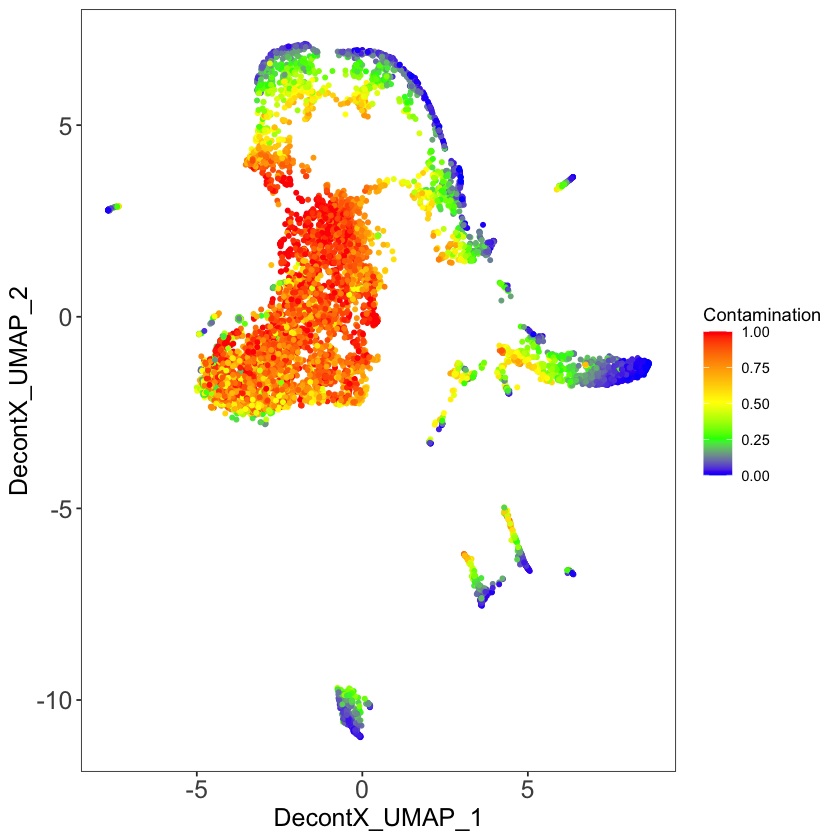

In [24]:
plotDecontXContamination(sce)

In [27]:
# --- decontX results for SingleCellExperiment (sce) ---
# Defensive check: make sure 'sce' is actually a SingleCellExperiment. If not, show explicit error and halt.
if (!("SingleCellExperiment" %in% class(sce))) {
  err_msg <- paste0(
    "Error: Could not find a SingleCellExperiment object inside 'sce' (it is a ",
    if (is.list(sce)) "list of class: list" else paste0("object of class: ", paste(class(sce), collapse=", ")),
    "). Please check your decontX output.\n"
  )
  stop(err_msg)
}

# Check that reducedDims generic/method is available and returns expected structure
# Defensive: Try to get UMAP from reducedDims if possible, else error
umap <- NULL
get_umap_dim <- function(sce) {
  out <- tryCatch({
    rd <- reducedDims(sce)
    if ("decontX_UMAP" %in% names(rd)) {
      reducedDim(sce, "decontX_UMAP")
    } else if (length(rd) > 0) {
      warning("UMAP not found as 'decontX_UMAP' in reducedDims(sce). Using the first reducedDim slot.")
      rd[[1]]
    } else {
      stop("No reduced dimensions (e.g., UMAP) found in reducedDims(sce) after decontX.")
    }
  }, error=function(e) {
    stop("Failed to extract reducedDims (UMAP): ", e$message)
  })
  out
}
umap <- get_umap_dim(sce)
if (is.null(umap)) stop("Unable to obtain UMAP from reducedDims(sce).")

# Check that the reduced dim is a proper matrix/data.frame
if (!is.matrix(umap) && !is.data.frame(umap)) {
  stop("Extracted UMAP is not a matrix/data.frame. Got class: ", paste(class(umap), collapse=", "))
}
if (ncol(umap)<2) stop("UMAP reduced dimension must have at least 2 columns.")

# decontX cluster labels are stored in colData(sce)$decontX_clusters
if ("decontX_clusters" %in% colnames(colData(sce))) {
  clusters <- colData(sce)$decontX_clusters
} else {
  stop("decontX cluster labels ('decontX_clusters') not found in colData(sce).")
}

# Plot decontX cluster labels
plotDimReduceCluster(
  x = clusters,
  dim1 = umap[, 1], dim2 = umap[, 2]
)

# Plot percentage of marker genes detected in each cell cluster before decontamination
plotDecontXMarkerPercentage(sce, markers = s$markers, assayName = "counts")

# After decontamination: by decontXcounts assay
plotDecontXMarkerPercentage(sce, markers = s$markers, assayName = "decontXcounts")

# Compare both (original and decontaminated)
plotDecontXMarkerPercentage(sce, markers = s$markers, assayName = c("counts", "decontXcounts"))

# Plot raw counts of individual marker genes before/after decontamination
plotDecontXMarkerExpression(sce, unlist(s$markers))

ERROR: Object 'sce' is not a SingleCellExperiment. Got class: list 


ERROR: Error: Could not find a SingleCellExperiment object inside 'sce' (it is a list of class: list). Please check your decontX output.


In [ ]:

# =============================================================================
# IMPORTANT: Verify cell preservation
# =============================================================================
cat("CELL TRACKING\n")
cat(rep("=", 50), "\n", sep="")

# Helper function to get number of columns robustly
safe_ncol <- function(x) {
  res <- tryCatch({
    if (!is.null(x) && !is(x, "logical") && !is(x, "integer") && !is(x, "numeric")) {
      ncol(x)
    } else {
      NA_integer_
    }
  }, error=function(e) { NA_integer_ })
  if (length(res) == 1 && !is.null(res) && !is.na(res)) return(res)
  NA_integer_
}

in_cells <- safe_ncol(x)
out_cells <- safe_ncol(sce)

cat("Input cells to decontX:", ifelse(is.na(in_cells), "NA", in_cells), "\n")
cat("Output cells from decontX:", ifelse(is.na(out_cells), "NA", out_cells), "\n")

if (!is.na(in_cells) && !is.na(out_cells)) {
  cat("Cells preserved:", out_cells == in_cells, "\n")
  if (out_cells != in_cells) {
    warning("Cell count changed! This should not happen with decontX.")
  }
} else {
  cat("Cells preserved: NA (could not determine ncol for input/output)\n")
  warning("Could not determine input or output cell count for cell tracking step (ncol(x)/ncol(sce)).")
}

cat("\n")

# =============================================================================
# Check contamination levels
# =============================================================================
contamination <- sce$decontX_contamination

cat("CONTAMINATION SUMMARY\n")
cat(rep("=", 50), "\n", sep="")
cat("Mean contamination:", round(mean(contamination, na.rm = TRUE) * 100, 2), "%\n")
cat("Median contamination:", round(median(contamination, na.rm = TRUE) * 100, 2), "%\n")
cat("Min contamination:", round(min(contamination, na.rm = TRUE) * 100, 2), "%\n")
cat("Max contamination:", round(max(contamination, na.rm = TRUE) * 100, 2), "%\n\n")

cat("Contamination distribution:\n")
cat("  < 5%:", sum(contamination < 0.05, na.rm = TRUE), "cells\n")
cat("  5-10%:", sum(contamination >= 0.05 & contamination < 0.10, na.rm = TRUE), "cells\n")
cat("  10-20%:", sum(contamination >= 0.10 & contamination < 0.20, na.rm = TRUE), "cells\n")
cat("  20-30%:", sum(contamination >= 0.20 & contamination < 0.30, na.rm = TRUE), "cells\n")
cat("  > 30%:", sum(contamination >= 0.30, na.rm = TRUE), "cells\n")
cat("  > 50%:", sum(contamination >= 0.50, na.rm = TRUE), "cells (consider QC)\n")
cat("  > 80%:", sum(contamination >= 0.80, na.rm = TRUE), "cells (extreme)\n\n")

# =============================================================================
# Check if cells might fail downstream QC
# =============================================================================
cat("QUALITY CHECK - Cells that might fail typical filters:\n")
cat(rep("=", 50), "\n", sep="")

# The decontXcounts() error is likely due to class compatibility issues.
# Sometimes celda::decontX (depending on version and input) can return a list instead of a SingleCellExperiment.
# Patch: If the output is a named list with an element containing the SingleCellExperiment, extract it.

get_valid_sce <- function(obj) {
  # If already SingleCellExperiment, return as-is.
  if (is(obj, "SingleCellExperiment")) return(obj)
  # If it's a list, and any element is an SCE, use that.
  if (is.list(obj)) {
    for (el in obj) {
      if (is(el, "SingleCellExperiment")) return(el)
    }
    # Could not find an SCE in the list, return as-is so error is caught below.
  }
  obj
}

sce_valid <- get_valid_sce(sce)

# Try/catch for decontXcounts compatibility
decon_counts <- NULL
decon_error <- NULL
tryCatch({
  decon_counts <- celda::decontXcounts(sce_valid)
}, error = function(e) {
  decon_error <<- e
})

if (!is.null(decon_error) || is.null(decon_counts)) {
  cat("\nERROR extracting decontaminated counts!\n")
  if (!is.null(decon_error)) cat("  Error: ", decon_error$message, "\n")
  cat("Attempting fallback: try extracting counts from $decontXcounts slot (if present)...\n")
  if ("decontXcounts" %in% SummarizedExperiment::assayNames(sce_valid)) {
    decon_counts <- SummarizedExperiment::assay(sce_valid, "decontXcounts")
    cat("  Fallback succeeded: 'decontXcounts' assay extracted.\n")
  } else {
    stop("decontXcounts() failed, and no 'decontXcounts' assay present!")
  }
}

decon_totals <- colSums(decon_counts)
decon_ngenes <- colSums(decon_counts > 0)

cat("\nBefore decontX:\n")
cat("  Cells < 500 counts:", sum(colSums(counts(x)) < 500), "\n")
cat("  Cells < 100 genes:", sum(colSums(counts(x) > 0) < 100), "\n")

cat("\nAfter decontX:\n")
cat("  Cells < 500 counts:", sum(decon_totals < 500), "\n")
cat("  Cells < 100 genes:", sum(decon_ngenes < 100), "\n")

if (sum(decon_totals < 500) > sum(colSums(counts(x)) < 500)) {
  cat("\nWARNING: More cells fall below QC thresholds after decontX!\n")
  cat("   This is normal - contamination was masking low-quality cells.\n")
  cat("   Recommendation: Use lenient filtering OR filter before decontX.\n")
}

cat("\n")

# Plot histogram of contamination using a validated color
tryCatch({
  hist(
    contamination * 100,
    breaks = 50,
    main = "Distribution of Contamination Levels (pyED)",
    xlab = "Contamination (%)",
    ylab = "Number of cells",
    col = pyED_color,
    border = "white"
  )
}, error = function(e) {
  warning(sprintf(
    "Error in plotting histogram with color '%s': %s. Falling back to 'dodgerblue'.",
    pyED_color, e$message
  ))
  hist(
    contamination * 100,
    breaks = 50,
    main = "Distribution of Contamination Levels (pyED)",
    xlab = "Contamination (%)",
    ylab = "Number of cells",
    col = "dodgerblue",
    border = "white"
  )
})

# =============================================================================
# Visualizations (if UMAP available)
# =============================================================================
cat("Preparing visualizations...\n")

# Try to get UMAP from EmptyDrops data
if ("X_umap" %in% names(ad_fg@int_elementMetadata)) {
  cat("Found UMAP coordinates in EmptyDrops data\n")

  umap_coords <- ad_fg@int_elementMetadata$X_umap
  m <- match(norm_bc(colnames(sce_valid)), fg_bc_norm)
  reducedDim(sce_valid, "UMAP") <- umap_coords[m[!is.na(m)], ]

  # Plot contamination on UMAP (use pyED color as highlight for colormap; not used by default function,
  # but can use in custom plot if desired)
  plotDecontXContamination(
    sce_valid, 
    main = "decontX Contamination of pyED-filtered cells",
    col = pyED_color # For S4 plotting, might be ignored; see below custom plot
  )

  # Plot decontX cluster labels
  umap <- reducedDim(sce_valid, "UMAP")
  plotDimReduceCluster(x = sce_valid$decontX_clusters,
                       dim1 = umap[, 1], 
                       dim2 = umap[, 2],
                       main = "decontX Cluster Assignments")

} else {
  cat("No UMAP coordinates found\n")
  cat("   Run UMAP first or use scater::runUMAP(sce)\n")
}

# =============================================================================
# Marker gene analysis (if you have markers defined)
# =============================================================================
# Uncomment and customize this section if you have marker genes
#
# markers <- list(
#   Spermatogonia = c("UTF1", "MAGEA4", "UCHL1"),
#   Spermatocytes = c("SYCP3", "TEX11", "PIWIL1"),
#   Spermatids = c("PRM1", "PRM2", "TNP1", "ACRV1"),
#   Leydig = c("INSL3", "DLK1", "CFD"),
#   Sertoli = c("SOX9", "AMH", "CTSL"),
#   Macrophages = c("CD163", "CD68", "C1QA")
# )
#
# # Plot marker percentage before and after decontamination
# plotDecontXMarkerPercentage(sce_valid, 
#                            markers = markers, 
#                            assayName = c("counts", "decontXcounts"))
#
# # Plot individual marker gene expression
# plotDecontXMarkerExpression(sce_valid, unlist(markers))

# =============================================================================
# Save results
# =============================================================================
cat("\nSaving decontaminated data...\n")

# Get decontaminated counts, ensure they were set above
decon <- decon_counts

out_prefix <- "./decontX_output"

# Save as H5AD for Python/Scanpy
cat("  - Saving as H5AD...\n")
zellkonverter::writeH5AD(sce_valid, 
                        paste0(out_prefix, ".h5ad"), 
                        X_name = "decontXcounts")

# Save as HDF5SummarizedExperiment for R (instead of saveRDS(), since object contains out-of-memory data)
cat("  - Saving as HDF5SummarizedExperiment (R/HDF5)...\n")
saveHDF5SummarizedExperiment(sce_valid, dir = paste0(out_prefix, "_h5se"))

# Optionally save sparse matrix
cat("  - Saving sparse matrix (MTX)...\n")
tryCatch({
  decon_csr <- as(Matrix::Matrix(decon, sparse = TRUE), "dgCMatrix")
  Matrix::writeMM(decon_csr, paste0(out_prefix, "_matrix.mtx"))
}, error = function(e) {
  cat("  Could not save MTX:", e$message, "\n")
})

cat("\nAll done!\n\n")
cat("Output files:\n")
cat("  -", paste0(out_prefix, ".h5ad"), "(for Python/Scanpy)\n")
cat("  -", paste0(out_prefix, "_h5se"), "(for R/HDF5SummarizedExperiment)\n")
cat("  -", paste0(out_prefix, "_matrix.mtx"), "(sparse matrix)\n\n")

# =============================================================================
# Optional: Create filtered version with lenient thresholds
# =============================================================================
# cat("OPTIONAL: Creating leniently filtered version...\n")
# cat(rep("=", 50), "\n", sep="")

# # Only remove cells that are EXTREMELY problematic
# keep_lenient <- (
#   contamination < 0.8 &              # Not extremely contaminated (>80%)
#   decon_totals > 200 &               # At least 200 counts (lenient!)
#   decon_ngenes > 50                  # At least 50 genes (lenient!)
# )

# cat("Lenient filtering criteria:\n")
# cat("  - Contamination < 80%\n")
# cat("  - Counts > 200\n")
# cat("  - Genes > 50\n\n")

# cat("Results:\n")
# cat("  Original cells:", ncol(sce_valid), "\n")
# cat("  Cells passing filter:", sum(keep_lenient), "\n")
# cat("  Cells removed:", sum(!keep_lenient), "\n")
# cat("  Retention rate:", round(sum(keep_lenient) / ncol(sce_valid) * 100, 1), "%\n\n")

# if (sum(keep_lenient) > 100) {  # Only save if we have reasonable number of cells
#   sce_filtered <- sce_valid[, keep_lenient]

#   cat("  Saving filtered version...\n")
#   zellkonverter::writeH5AD(sce_filtered, 
#                           paste0(out_prefix, "_filtered.h5ad"), 
#                           X_name = "decontXcounts")
#   saveHDF5SummarizedExperiment(sce_filtered, dir = paste0(out_prefix, "_filtered_h5se"))

#   cat("  - ", paste0(out_prefix, "_filtered.h5ad"), "\n")
#   cat("  - ", paste0(out_prefix, "_filtered_h5se"), "\n\n")
# } else {
#   cat("  Too few cells pass filter (", sum(keep_lenient), "), not saving filtered version.\n\n")
# }

# cat("SUMMARY\n")
# cat(rep("=", 50), "\n", sep="")
# cat("decontX completed successfully\n")
# cat("All", ncol(sce_valid), "cells preserved\n")
# cat("Mean contamination:", round(mean(contamination) * 100, 1), "%\n")
# if (sum(keep_lenient) > 100) {
#   cat("Filtered version created with", sum(keep_lenient), "cells\n")
# }
# cat("\n")

# cat("Next steps:\n")
# cat("  1. Check contamination levels\n")
# cat("  2. Use filtered version for UMAP/analysis (recommended)\n")
# cat("  3. Or use unfiltered version with lenient downstream filtering\n")
# cat("  4. Compare original vs decontaminated counts\n\n")

# cat("IMPORTANT: To avoid losing cells in downstream analysis:\n")
# cat("  - Use the _filtered.h5ad version (already has lenient QC)\n")
# cat("  - OR in Python, use lenient filtering:\n")
# cat("      sc.pp.filter_cells(adata, min_genes=50)  # NOT 100\n")
# cat("      sc.pp.filter_cells(adata, min_counts=200)  # NOT 500\n")

In [3]:
# run GSEA on the "decontX_output.h5ad" file
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

decontx = sc.read_h5ad("decontX_output.h5ad")
foreground = sc.read_h5ad("../data/pyED_correct.h5ad")
raw = sc.read_10x_h5("../11_decontX/00_data/raw.h5")
foreground.var_names_make_unique
raw.var_names_make_unique
print("decontx: ", decontx.shape)
print("raw: ", raw.shape)
print("foreground: ", foreground.shape)
# create background from raw - foreground
background = raw[:, foreground.obs_names]

# print shapes for all loaded data


decontx:  (8202, 61313)
raw:  (722431, 22040)
foreground:  (8202, 22040)


/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [ ]:
print(decontx.var)
# filter for gene expression
decontx_gene_exp = decontx[:, decontx.var['Type'] == 'Gene Expression']
decontx_gene_exp

# i only got Pig Ensembl IDs starting with ENSSSCG
# so I do it like this

type_col = "Type" if "Type" in decontx.var.columns else None
if type_col is not None:
    decontx = decontx[:, decontx.var[type_col] == "Gene Expression"].copy()

# Use gene symbols as var_names
if "Symbol" in decontx.var.columns:
    symbols = decontx.var["Symbol"].astype(str).values
    # Fallback for missing/empty symbols
    mask = (symbols == "") | pd.isna(symbols)
    if mask.any():
        symbols[mask] = decontx.var_names[mask]
    decontx.var_names = symbols
    decontx.var_names_make_unique()

decontx.write_h5ad("decontx_output_trimmed_gex.h5ad")

                                    ID              Symbol             Type
ALDH1A1             ENSSSCG00000028996             ALDH1A1  Gene Expression
ANXA1               ENSSSCG00000005267               ANXA1  Gene Expression
RORB                ENSSSCG00000005268                RORB  Gene Expression
TRPM6               ENSSSCG00000005269               TRPM6  Gene Expression
C9orf40             ENSSSCG00000031382             C9orf40  Gene Expression
...                                ...                 ...              ...
ND4                 ENSSSCG00000018087                 ND4  Gene Expression
ND5                 ENSSSCG00000018091                 ND5  Gene Expression
ND6                 ENSSSCG00000018092                 ND6  Gene Expression
CYTB                ENSSSCG00000018094                CYTB  Gene Expression
ENSSSCG00000034846  ENSSSCG00000034846  ENSSSCG00000034846  Gene Expression

[22040 rows x 3 columns]


In [ ]:
# load decontx_output_trimmed_gex.h5ad
decontx = sc.read_h5ad("decontx_output_trimmed_gex.h5ad")

# check dimensions
print(decontx.shape)

# check var
print("VAR: ", decontx.var)

print("OBS: ",decontx.obs)

print(decontx.X)

(14997, 22040)
VAR:                                      ID              Symbol             Type
ALDH1A1             ENSSSCG00000028996             ALDH1A1  Gene Expression
ANXA1               ENSSSCG00000005267               ANXA1  Gene Expression
RORB                ENSSSCG00000005268                RORB  Gene Expression
TRPM6               ENSSSCG00000005269               TRPM6  Gene Expression
C9orf40             ENSSSCG00000031382             C9orf40  Gene Expression
...                                ...                 ...              ...
ND4                 ENSSSCG00000018087                 ND4  Gene Expression
ND5                 ENSSSCG00000018091                 ND5  Gene Expression
ND6                 ENSSSCG00000018092                 ND6  Gene Expression
CYTB                ENSSSCG00000018094                CYTB  Gene Expression
ENSSSCG00000034846  ENSSSCG00000034846  ENSSSCG00000034846  Gene Expression

[22040 rows x 3 columns]
OBS:                                     